In [241]:
import pandas as pd
import numpy as np
import platform
import matplotlib.pyplot as plt
%matplotlib inline

path = 'c:/Windows/Fonts/malgun.ttf'
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~')

In [242]:
from selenium import webdriver
import time

In [243]:
driver=webdriver.Chrome("../driver/chromedriver.exe")
driver.get("http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09")

In [244]:
#driver.close()

In [245]:
#대통령 선거
#driver.find_element_by_xpath("""//*[@id="electionType1"]""").click()
driver.find_element_by_id("electionType1").click()

In [246]:
driver.find_element_by_id("electionName").send_keys("제19대")

In [247]:
driver.find_element_by_id("electionCode").send_keys("대통령선거")

In [345]:
sido_list_raw=driver.find_element_by_xpath("""//*[@id="cityCode"]""")
sido_list = sido_list_raw.find_elements_by_tag_name("option")

InvalidSessionIdException: Message: invalid session id


In [249]:
sido_names_values_raw = [ option.text for option in sido_list ]
sido_names_values=sido_names_values_raw[2:]
sido_names_values

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [250]:
import re
def get_num(tmp):
    return float(re.split("\(",tmp)[0].replace(",",""))

In [251]:
tmp="한국3,000()"
re.split("\(",tmp)[0].replace(",","")

'한국3000'

https://selenium-python.readthedocs.io/waits.html

In [252]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

wait=WebDriverWait(driver, 10)
def move_sido(name):
    element=driver.find_element_by_id("cityCode")
    element.send_keys(name)
    make_xpath="""//*[@id="searchBtn"]"""

    
    wait.until(EC.element_to_be_clickable((By.XPATH,make_xpath)))
    driver.find_element_by_xpath(make_xpath).click()
    ##SPATH속성이 make_xpath인 element가 리턴될때까지 

In [253]:
def append_data(df,sido_name,data):
    for each in df[0].values[1:]:
        data["광역시도"].append(sido_name)
        data["시군"].append(each[0])
        data["pop"].append(float(each[2]))
        data["moon"].append(get_num(each[3]))
        data["hong"].append(get_num(each[4]))
        data["ahn"].append(get_num(each[5]))

In [254]:
election_result_raw={"광역시도":[],
                    "시군":[],
                    "pop":[],
                    "moon":[],
                    "hong":[],
                    "ahn":[]}

In [255]:
from bs4 import BeautifulSoup
for each_sido in sido_names_values:
    move_sido(each_sido)
    
    html = driver.page_source
    soup=BeautifulSoup(html,"html.parser")
    table=soup.find("table")
    #read_html()은 HTML프레임에 여러개의 테이블이 있을 수 있는 데이터
    #데이터 프레임 몱록을 생성하고 원하는 인덱스를 인덱스로 가져옴
    df=pd.read_html(str(table))
    append_data(df,each_sido,election_result_raw)
    

In [256]:
election_result=pd.DataFrame(election_result_raw,
                            columns=["광역시도","시군","pop","moon","hong","ahn"])
election_result.head()

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0


In [257]:
election_result.to_csv("../data/election_result.csv",encoding="utf-8",sep=",")

In [258]:
driver.close()

각 후보의 득표율과 지역 id정리하기

In [260]:
election_result=pd.read_csv("../data/election_result.csv",encoding="utf-8",sep=",",index_col=0)
election_result.head()

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0


In [274]:
sido_candi=election_result["광역시도"]
sido_candi=[name[:2] if name[:2] in ["서울","부산","대구","광주","인천","대전","울산"]
           else "" for name in sido_candi]
#"":제주특별시,경기도,강원도,....

In [278]:
#중랑구->중랑,마포...
def cut_char_sigu(name):
    return name if len(name)==2 else name[:-1]

In [263]:
sigun_candi = ['']*len(election_result)
for n in election_result.index:
    each = election_result['시군'][n]
    if each[:2] in ['수원','성남','안양','안산','고양','용인','청주','천안','전주','포항','창원']:
        sigun_candi[n] = re.split('시',each)[0]+' ' + cut_char_sigu(re.split('시', each)[1])
    else:
        sigun_candi[n] = cut_char_sigu(each)
sigun_candi

['종로',
 '중구',
 '용산',
 '성동',
 '광진',
 '동대문',
 '중랑',
 '성북',
 '강북',
 '도봉',
 '노원',
 '은평',
 '서대문',
 '마포',
 '양천',
 '강서',
 '구로',
 '금천',
 '영등포',
 '동작',
 '관악',
 '서초',
 '강남',
 '송파',
 '강동',
 '중구',
 '서구',
 '동구',
 '영도',
 '부산진',
 '동래',
 '남구',
 '북구',
 '해운대',
 '기장',
 '사하',
 '금정',
 '강서',
 '연제',
 '수영',
 '사상',
 '중구',
 '동구',
 '서구',
 '남구',
 '북구',
 '수성',
 '달서',
 '달성',
 '중구',
 '동구',
 '남구',
 '연수',
 '남동',
 '부평',
 '계양',
 '서구',
 '강화',
 '옹진',
 '동구',
 '서구',
 '남구',
 '북구',
 '광산',
 '동구',
 '중구',
 '서구',
 '유성',
 '대덕',
 '중구',
 '남구',
 '동구',
 '북구',
 '울주',
 '세종특별자치',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남',
 '파주',
 '여주',
 '이천',
 '용인 처인',
 '용인 수지',
 '용인 기흥',
 '안성',
 '김포',
 '광주',
 '포천',
 '연천',
 '양평',
 '가평',
 '춘천',
 '원주',
 '강릉',
 '동해',
 '삼척',
 '태백',
 '정선',
 '속초',
 '고성',
 '양양',
 '인제',
 '홍천',
 '횡성',
 '영월',
 '평창',
 '화천',
 '양구

In [289]:
ID_candi = [sido_candi[n]+' '+sigun_candi[n] for n in range(0, len(sigun_candi))]
ID_candi = [name[1:] if name[0] == ' 'else name for name in ID_candi]
ID_candi = [name[:2] if name[:2] =='세종' else name for name in ID_candi]
ID_candi

['서울 종로',
 '서울 중구',
 '서울 용산',
 '서울 성동',
 '서울 광진',
 '서울 동대문',
 '서울 중랑',
 '서울 성북',
 '서울 강북',
 '서울 도봉',
 '서울 노원',
 '서울 은평',
 '서울 서대문',
 '서울 마포',
 '서울 양천',
 '서울 강서',
 '서울 구로',
 '서울 금천',
 '서울 영등포',
 '서울 동작',
 '서울 관악',
 '서울 서초',
 '서울 강남',
 '서울 송파',
 '서울 강동',
 '부산 중구',
 '부산 서구',
 '부산 동구',
 '부산 영도',
 '부산 부산진',
 '부산 동래',
 '부산 남구',
 '부산 북구',
 '부산 해운대',
 '부산 기장',
 '부산 사하',
 '부산 금정',
 '부산 강서',
 '부산 연제',
 '부산 수영',
 '부산 사상',
 '대구 중구',
 '대구 동구',
 '대구 서구',
 '대구 남구',
 '대구 북구',
 '대구 수성',
 '대구 달서',
 '대구 달성',
 '인천 중구',
 '인천 동구',
 '인천 남구',
 '인천 연수',
 '인천 남동',
 '인천 부평',
 '인천 계양',
 '인천 서구',
 '인천 강화',
 '인천 옹진',
 '광주 동구',
 '광주 서구',
 '광주 남구',
 '광주 북구',
 '광주 광산',
 '대전 동구',
 '대전 중구',
 '대전 서구',
 '대전 유성',
 '대전 대덕',
 '울산 중구',
 '울산 남구',
 '울산 동구',
 '울산 북구',
 '울산 울주',
 '세종',
 '수원 장안',
 '수원 권선',
 '수원 팔달',
 '수원 영통',
 '성남 수정',
 '성남 중원',
 '성남 분당',
 '의정부',
 '안양 만안',
 '안양 동안',
 '부천',
 '광명',
 '평택',
 '양주',
 '동두천',
 '안산 상록',
 '안산 단원',
 '고양 덕양',
 '고양 일산동',
 '고양 일산서',
 '과천',
 '의왕',
 '구리',
 '남양주',
 '오산',
 '화성',
 '시흥',
 '군포',
 '하남'

In [298]:
election_result["ID"]=ID_candi
election_result.head(10)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249
5,서울특별시,동대문구,236092.0,98958.0,51631.0,53359.0,서울 동대문,41.915016,21.869017,22.600935
6,서울특별시,중랑구,265706.0,111450.0,56545.0,62778.0,서울 중랑,41.944856,21.281040,23.626866
7,서울특별시,성북구,295866.0,129263.0,57584.0,66518.0,서울 성북,43.689711,19.462865,22.482475
8,서울특별시,강북구,210614.0,89645.0,42268.0,51669.0,서울 강북,42.563647,20.068941,24.532557
9,서울특별시,도봉구,229233.0,94898.0,47461.0,55600.0,서울 도봉,41.398054,20.704262,24.254798


In [299]:
election_result[["rate_moon","rate_hong","rate_ahn"]]= election_result[["moon","hong","ahn"]].div(election_result["pop"],axis=0)
election_result[["rate_moon","rate_hong","rate_ahn"]]*=100
election_result.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249


In [300]:
election_result.sort_values(["rate_moon"],ascending=[False]).head(5)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
182,전라남도,순천시,181451.0,122595.0,4525.0,40429.0,순천,67.563695,2.493786,22.280946
166,전라북도,전주시덕진구,187921.0,125375.0,5183.0,40188.0,전주 덕진,66.716865,2.758074,21.385582
165,전라북도,전주시완산구,236383.0,157637.0,7003.0,50506.0,전주 완산,66.687114,2.962565,21.366173
175,전라북도,장수군,16079.0,10714.0,717.0,3353.0,장수,66.633497,4.459233,20.853287
184,전라남도,광양시,96384.0,63544.0,4100.0,20080.0,광양,65.927955,4.253818,20.833333


In [301]:
election_result.sort_values(["rate_hong"],ascending=[False]).head(5)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
219,경상북도,군위군,17627.0,2251.0,11651.0,1939.0,군위,12.770182,66.097464,11.000170
220,경상북도,의성군,37855.0,5365.0,23790.0,4767.0,의성,14.172500,62.845067,12.592788
223,경상북도,영덕군,26125.0,3786.0,16314.0,3231.0,영덕,14.491866,62.445933,12.367464
247,경상남도,합천군,33021.0,7143.0,19699.0,3077.0,합천,21.631689,59.655976,9.318313
216,경상북도,고령군,22396.0,3754.0,13248.0,2600.0,고령,16.761922,59.153420,11.609216


In [302]:
election_result.sort_values(["rate_ahn"],ascending=[False]).head(5)

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
196,전라남도,진도군,21189.0,10392.0,511.0,8855.0,진도,49.044315,2.411629,41.790552
201,전라남도,신안군,28950.0,14370.0,713.0,12000.0,신안,49.637306,2.462867,41.450777
193,전라남도,강진군,25175.0,12476.0,753.0,10152.0,강진,49.557100,2.991063,40.325720
195,전라남도,해남군,48351.0,25901.0,1158.0,18157.0,해남,53.568696,2.394987,37.552481
197,전라남도,영암군,36402.0,18999.0,825.0,13610.0,영암,52.192187,2.266359,37.388056


In [303]:
draw_korea=pd.read_csv("../data/05. draw_korea.csv",encoding="utf-8",index_col=0)
draw_korea.head()

,y,x,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [306]:
set(draw_korea['ID'].unique() )  -  set( election_result['ID'].unique() )

{'고성(강원)', '고성(경남)', '부천 소사', '부천 오정', '부천 원미', '창원 합포', '창원 회원'}

In [307]:
set( election_result['ID'].unique() ) - set( draw_korea['ID'].unique() )

{'고성', '부천', '창원 마산합포', '창원 마산회원'}

In [308]:
election_result[ election_result['ID'] == '고성' ]

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성,30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성,28.459960,48.542034,11.860243


In [311]:
election_result.loc[125, 'ID'] = '고성(강원)'
election_result.loc[233, 'ID'] = '고성(경남)'

election_result[election_result['시군'] == '고성군']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성(강원),30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243


In [312]:
election_result.loc[228, 'ID'] = '창원 합포'
election_result.loc[229, 'ID'] = '창원 회원'
election_result[ election_result['광역시도'] == '경상남도' ][:5]


,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061


In [313]:
set(draw_korea['ID']) - set(election_result['ID'])

{'부천 소사', '부천 오정', '부천 원미'}

In [314]:
set(election_result['ID']) - set(draw_korea['ID'])

{'부천'}

In [315]:
ahn_tmp = election_result.loc[85, 'ahn']/3
hong_tmp = election_result.loc[85, 'hong']/3
moon_tmp = election_result.loc[85, 'moon']/3
pop_tmp = election_result.loc[85, 'moon']/3
rate_moon_tmp = election_result.loc[85, 'rate_moon']
rate_hong_tmp = election_result.loc[85, 'rate_hong']
rate_ahn_tmp = election_result.loc[85, 'rate_ahn']

In [316]:
election_result.loc[250] = ['경기도', '부천시', pop_tmp, moon_tmp, hong_tmp, ahn_tmp, 
                            "부천 소사", rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[251] = ['경기도', '부천시', pop_tmp, moon_tmp, hong_tmp, ahn_tmp, 
                            "부천 오정", rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[252] = ['경기도', '부천시', pop_tmp, moon_tmp, hong_tmp, ahn_tmp, 
                            "부천 원미", rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]

In [317]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
85,경기도,부천시,543777.0,239697.0,100544.000000,128297.000000,부천,44.080018,18.489932,23.593679
250,경기도,부천시,79899.0,79899.0,33514.666667,42765.666667,부천 소사,44.080018,18.489932,23.593679
251,경기도,부천시,79899.0,79899.0,33514.666667,42765.666667,부천 오정,44.080018,18.489932,23.593679
252,경기도,부천시,79899.0,79899.0,33514.666667,42765.666667,부천 원미,44.080018,18.489932,23.593679


In [318]:
election_result.drop([85], inplace=True)
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
250,경기도,부천시,79899.0,79899.0,33514.666667,42765.666667,부천 소사,44.080018,18.489932,23.593679
251,경기도,부천시,79899.0,79899.0,33514.666667,42765.666667,부천 오정,44.080018,18.489932,23.593679
252,경기도,부천시,79899.0,79899.0,33514.666667,42765.666667,부천 원미,44.080018,18.489932,23.593679


In [319]:
set(draw_korea['ID']) - set(election_result['ID'])

set()

In [320]:
set(election_result['ID']) - set(draw_korea['ID'])

set()

In [321]:
final_elect_data=pd.merge(election_result,draw_korea,how="left",on=["ID"])
final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773,4,6
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451,5,6
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280,6,6
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128,5,7
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249,6,7


In [322]:
final_elect_data["moon_vs_hong"]=final_elect_data["rate_moon"]-final_elect_data["rate_hong"]
final_elect_data["moon_vs_ahn"]=final_elect_data["rate_moon"]-final_elect_data["rate_ahn"]
final_elect_data["ahn_vs_hong"]=final_elect_data["rate_ahn"]-final_elect_data["rate_hong"]
final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


In [323]:
final_elect_data.sort_values(["moon_vs_hong"],ascending=[False]).head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
181,전라남도,순천시,181451.0,122595.0,4525.0,40429.0,순천,67.563695,2.493786,22.280946,22,4,65.069909,45.282749,19.787160
165,전라북도,전주시덕진구,187921.0,125375.0,5183.0,40188.0,전주 덕진,66.716865,2.758074,21.385582,18,3,63.958791,45.331283,18.627508
164,전라북도,전주시완산구,236383.0,157637.0,7003.0,50506.0,전주 완산,66.687114,2.962565,21.366173,19,3,63.724549,45.320941,18.403608
63,광주광역시,광산구,248209.0,159119.0,3630.0,65402.0,광주 광산,64.106862,1.462477,26.349568,21,2,62.644384,37.757293,24.887091
171,전라북도,완주군,62470.0,41057.0,2107.0,13897.0,완주,65.722747,3.372819,22.245878,17,4,62.349928,43.476869,18.873059


In [324]:
final_elect_data.sort_values(["moon_vs_hong"],ascending=[True]).head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
218,경상북도,군위군,17627.0,2251.0,11651.0,1939.0,군위,12.770182,66.097464,11.000170,11,10,-53.327282,1.770012,-55.097294
219,경상북도,의성군,37855.0,5365.0,23790.0,4767.0,의성,14.172500,62.845067,12.592788,11,11,-48.672566,1.579712,-50.252278
222,경상북도,영덕군,26125.0,3786.0,16314.0,3231.0,영덕,14.491866,62.445933,12.367464,7,11,-47.954067,2.124402,-50.078469
215,경상북도,고령군,22396.0,3754.0,13248.0,2600.0,고령,16.761922,59.153420,11.609216,13,9,-42.391498,5.152706,-47.544204
212,경상북도,예천군,32124.0,5261.0,18863.0,4427.0,예천,16.377163,58.719338,13.780974,10,8,-42.342174,2.596190,-44.938364


In [326]:
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
     (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
     (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
     (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
     (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
     (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
    [(27,5), (27,6), (25,6)],
]

In [333]:
# 1. BORDER_LINES
# 2. def drawkorea
def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = 20.

    datalabel = targetData

    tmp_max = max([ np.abs(min(blockedMap[targetData])), 
                                  np.abs(max(blockedMap[targetData]))])
    vmin, vmax = -tmp_max, tmp_max

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

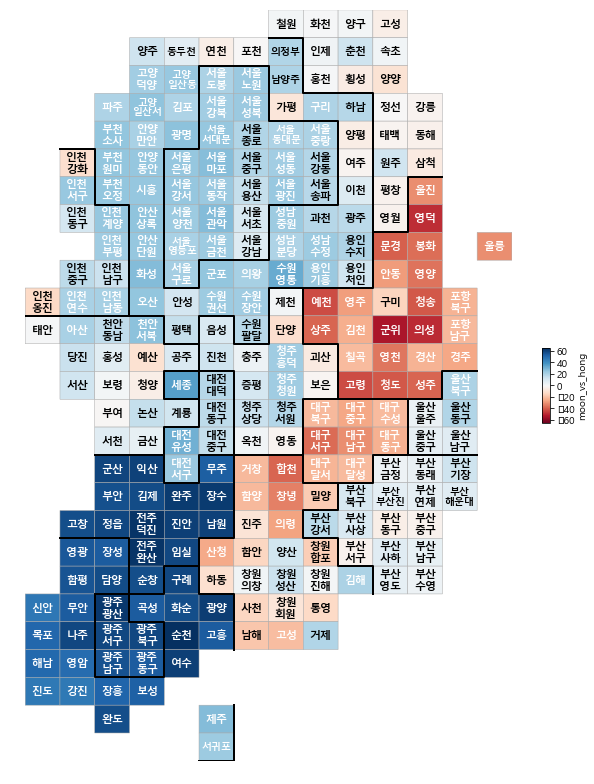

In [334]:
drawKorea("moon_vs_hong",final_elect_data,"RdBu")

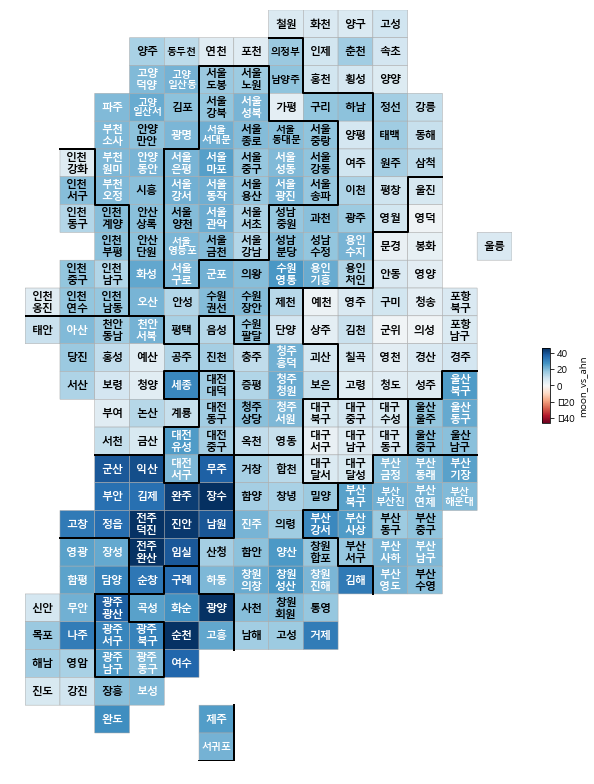

In [335]:
drawKorea("moon_vs_ahn",final_elect_data,"RdBu")

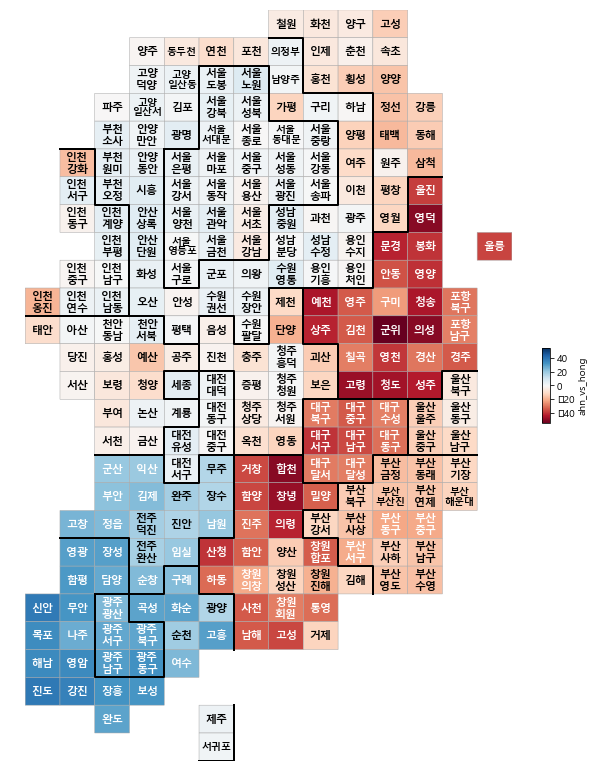

In [336]:
drawKorea("ahn_vs_hong",final_elect_data,"RdBu")

In [338]:
import folium
import json
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

In [340]:
pop_folium=final_elect_data.set_index("ID")
del pop_folium["광역시도"]
del pop_folium["시군"]
pop_folium.head()

,pop,moon,hong,ahn,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
ID,,,,,,,,,,,,
서울 종로,102566.0,42512.0,22325.0,22313.0,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
서울 중구,82852.0,34062.0,17901.0,19372.0,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
서울 용산,148157.0,58081.0,35230.0,32109.0,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
서울 성동,203175.0,86686.0,40566.0,45674.0,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
서울 광진,240030.0,105512.0,46368.0,52824.0,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


In [343]:
geo_path="../data/05. skorea_municipalities_geo_simple.json"
geo_str=json.load(open(geo_path,encoding="utf-8"))
map=folium.Map(location=[36.2002,127.054],zoom_start=6)
map.choropleth(geo_data=geo_str,
              data=pop_folium["moon_vs_hong"],
              columns=[pop_folium.index,pop_folium["moon_vs_hong"]],
              fill_color="RdBu",
              key_on="feature.id")
map